In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import re

### 1.4

In [23]:
G = nx.Graph()
G.add_nodes_from([1,2,3,4,5,6,7,8,9])
G.add_edges_from([(1, 3), (1, 5), (1, 7), (1, 9)])
G.add_edges_from([(2, 3), (2, 5), (2, 6)])
G.add_edges_from([(3, 2), (3, 7), (3, 1)])
G.add_edges_from([(4, 5), (4, 7), (4, 8)])
G.add_edges_from([(5, 1), (5, 2), (5, 4), (5, 9)])
G.add_edges_from([(6, 2), (6, 7), (6, 9)])
G.add_edges_from([(7, 1), (7, 3), (7, 4), (7, 6)])
G.add_edges_from([(8, 4), (8, 9)])
G.add_edges_from([(9, 1), (9, 5), (9, 6), (9, 8)])
G.to_undirected()

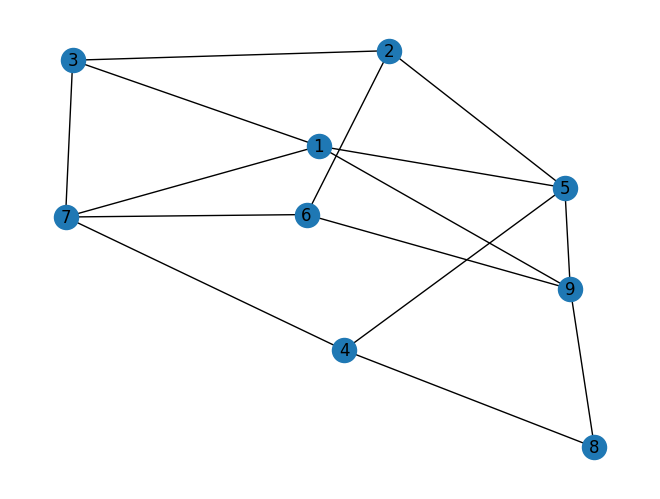

In [24]:
# Draw graph
nx.draw(G, with_labels=True)

In [25]:
print(nx.average_clustering(G))

0.12962962962962962


### 3.1

In [26]:
import numpy as np
import csv
import networkx as nx

Load twitter-small.tsv

In [27]:
tsvfile =  open("../datasets/twitter-small.tsv", encoding='gb18030', errors='ignore')
tsvReader = [each for each in csv.reader(tsvfile, delimiter='\t')]
tsvfile.close()

*Question1 : 'gbk' codec can't decode byte 0xaa in position 1444: illegal multibyte sequence*  
*Solution: encoding='gb18030', errors='ignore'*

In [28]:
# # find all word_index in a list
# def find_all_mention(alist, word):
#     start_index = -1
#     find_list = []
#     while(True):
#         current_find = alist.find(word, start_index+1)
#         if current_find == -1:
#             break
#         stop_point1 = alist.find(' ', current_find)
#         stop_point2 = alist.find(':', current_find)
#         if stop_point2 != -1:
#             stop_index = stop_point1 if stop_point1 < stop_point2 else stop_point2
#         else:
#             stop_index = stop_point1
#         start_index = current_find

#         find_list.append(alist[start_index+1 : stop_index]) 
#     return find_list

In [29]:
# find all word_index in a list
def find_all_user(alist):
    mention_list =  re.findall('@[a-zA-Z0-9_]{0,15}', alist)
    if len(mention_list) == 0:
        return -1
    for user in mention_list:
        i = 0
        if (user == '') | (user == '@'):
            del mention_list[i]
        i += 1
    return mention_list
    

In [30]:
Gs_dic = {}
for row in tsvReader:
    # row[0] : timestamp
    # row[1] : user
    # row[2] : tweet
    mention = find_all_user(row[2])
    if mention != -1:
        for each in mention:
            if len(each) != 0:
                if (row[1], each) not in Gs_dic.keys():
                    Gs_dic[(row[1], each)] = [row[0], 1]
                else:
                    Gs_dic[(row[1], each)][1] += 1

In [31]:
def preprocessing_Timestamp(timestamp):
    retimestamp = timestamp[:10]+'T'+timestamp[11:]
    return retimestamp

In [41]:
# with weights
with open("../datasets/twitter_weight_small.csv","w") as csvWrite: 
    nwriter = csv.writer(csvWrite,delimiter=' ')
    nwriter.writerow(['Source', 'Target', 'Weight', 'Timestamp'])
    for key in sorted(Gs_dic.keys()):
        timestamp = preprocessing_Timestamp(Gs_dic[key][0])
        if (key[0] != '') & (key[1][1:] != ''):
            nwriter.writerow([key[0],key[1][1:],Gs_dic[key][1],timestamp])

csvWrite.close()

In [42]:
# without weights
with open("../datasets/twitter_small.csv","w") as csvWrite: 
    nwriter = csv.writer(csvWrite,delimiter=' ')
    nwriter.writerow(['Source', 'Target'])
    for key in sorted(Gs_dic.keys()):
        timestamp = preprocessing_Timestamp(Gs_dic[key][0])
        if (key[0] != '') & (key[1][1:] != ''):
            nwriter.writerow([key[0],key[1][1:]])

csvWrite.close()

In [56]:
# adjlist list
Gs = nx.read_adjlist("../datasets/twitter_small.csv", create_using=nx.DiGraph())

with open("../datasets/twitter_adjust_small.csv","w") as csvWrite: 
    nwriter = csv.writer(csvWrite,delimiter=' ')
    for line in nx.generate_adjlist(Gs):
        nwriter.writerow([line])
csvWrite.close()